# Import csv from kaggle (code reference : https://www.kaggle.com/datasets/shivachandel/kc-house-data?select=kc_house_data.csv)

In [60]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("shivachandel/kc-house-data")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\sriva\.cache\kagglehub\datasets\shivachandel\kc-house-data\versions\1


In [61]:
import pandas as pd
import numpy as np
import os

#Build path to csv

In [62]:
csv_file = os.path.join(path, "kc_house_data.csv")

# Read CSV

In [63]:
df = pd.read_csv(csv_file)
df.head(10)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180.0,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170.0,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770.0,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050.0,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680.0,0,1987,0,98074,47.6168,-122.045,1800,7503
5,7237550310,20140512T000000,1225000.0,4,4.50,5420,101930,1.0,0,0,...,11,3890.0,1530,2001,0,98053,47.6561,-122.005,4760,101930
6,1321400060,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715.0,0,1995,0,98003,47.3097,-122.327,2238,6819
7,2008000270,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060.0,0,1963,0,98198,47.4095,-122.315,1650,9711
8,2414600126,20150415T000000,229500.0,3,1.00,1780,7470,1.0,0,0,...,7,1050.0,730,1960,0,98146,47.5123,-122.337,1780,8113
9,3793500160,20150312T000000,323000.0,3,2.50,1890,6560,2.0,0,0,...,7,1890.0,0,2003,0,98038,47.3684,-122.031,2390,7570


In [64]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Prepare data

In [65]:
df["date"] = pd.to_datetime(df["date"])
df["year"] = df["date"].dt.year
df["effective_year"] = np.where(df["yr_renovated"] == 0, df["yr_built"], df["yr_renovated"])
df["house_age"] = df["year"] - df["effective_year"]

drop_cols = ["id", "date", "year", "effective_year", "yr_built", "yr_renovated"]
target = "price"

X = df.drop(columns=[target] + drop_cols)
y = df[target].copy()

# log transform target for stability

In [66]:
y_log = np.log1p(y)

# Splitting the dataset

In [67]:
X_train, X_test, y_train_log, y_test_log = train_test_split(
    X, y_log, test_size=0.2, random_state=1
)

# Preprocessing

In [68]:
ordinal_like = ["waterfront", "view", "condition", "grade"]
categorical = ["zipcode"]
numeric = [c for c in X_train.columns if c not in categorical + ordinal_like]
numeric += ordinal_like

numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer([
    ("num", numeric_pipeline, numeric),
    ("cat", categorical_pipeline, categorical)
])

# Building a pipeline

In [69]:
model = LinearRegression()
pipe = Pipeline([
    ("pre", preprocessor),
    ("model", model)
])

# Fitting a model

In [70]:
pipe.fit(X_train, y_train_log)

,steps,"[('pre', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


# Performance Evaluation

In [71]:
y_pred_log = pipe.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_test = np.expm1(y_test_log)

mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print(f"Test R-squared:  {r2:.4f}")
print(f"Test RMSE: ${rmse:,.0f}")
print(f"Test MAE:  ${mae:,.0f}")

Test R-squared:  0.5355
Test RMSE: $283,146
Test MAE:  $84,589


# Coefficient importance - Extracting feature names here after preprocessing
# The practical search algorithm used to identify the six most important features was based on standardized coefficient magnitude ranking. After scaling all predictors in the preprocessing pipeline, the model’s coefficients were extracted, converted to absolute values and then aggregated by feature category (all one-hot “zipcode” columns combined). The features with the largest absolute standardized coefficients were considered most influential in predicting house prices.

In [72]:
pre = pipe.named_steps["pre"]
num_names = [f"num__{c}" for c in numeric]
ohe = pre.named_transformers_["cat"].named_steps["onehot"]
cat_names = [f"cat__{n}" for n in ohe.get_feature_names_out(categorical)]
feature_names = num_names + cat_names

coefs = pipe.named_steps["model"].coef_
coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefs,
    "Abs_Coefficient": np.abs(coefs)
}).sort_values(by="Abs_Coefficient", ascending=False)

coef_df["Spec"] = coef_df["Feature"].apply(
    lambda x: "zipcode" if x.startswith("cat__zipcode_") else x.replace("num__", "")
)
coef_by_spec = (coef_df.groupby("Spec")["Abs_Coefficient"]
                .sum()
                .sort_values(ascending=False)
                .reset_index())

print("\nTop 6 important specifications by coefficient magnitude:")
print(coef_by_spec.head(6))


Top 6 important specifications by coefficient magnitude:
            Spec  Abs_Coefficient
0        zipcode        15.610704
1     sqft_above         0.183024
2          grade         0.100032
3            lat         0.076821
4  sqft_basement         0.063529
5  sqft_living15         0.052588


# Visualizing this result to compare it with the whole feature set

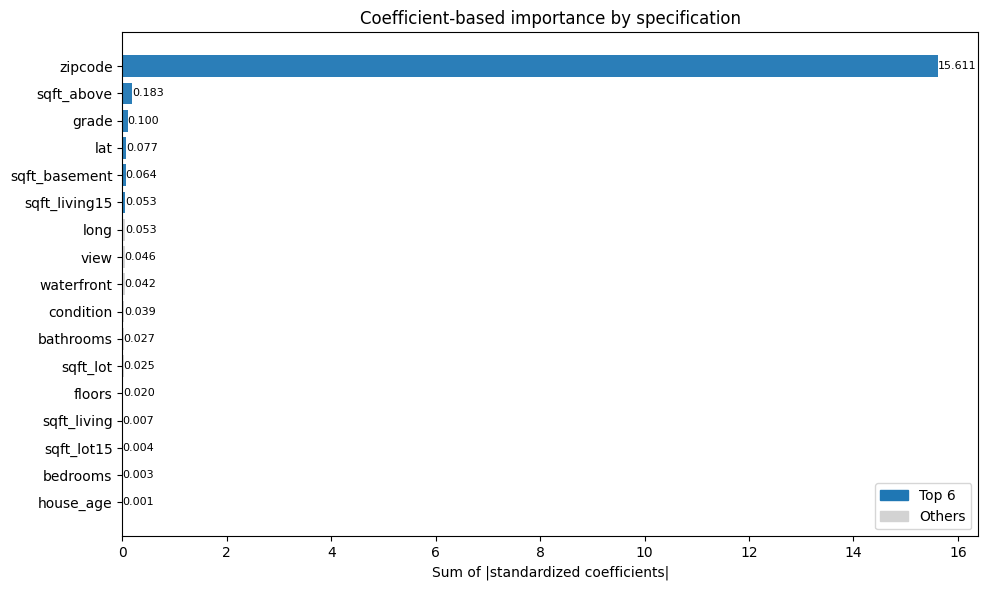

In [73]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

TOP_K = 6

plot_df = coef_by_spec.copy()
plot_df["is_top"] = plot_df["Spec"].isin(coef_by_spec["Spec"].head(TOP_K))

#sort
plot_df = plot_df.sort_values("Abs_Coefficient", ascending=True)

#color
colors = plot_df["is_top"].map({True: "#1f77b4", False: "#d3d3d3"})

plt.figure(figsize=(10, max(6, 0.35 * len(plot_df))))
bars = plt.barh(plot_df["Spec"], plot_df["Abs_Coefficient"], color=colors, alpha=0.95)

#adding value labels
for bar, val in zip(bars, plot_df["Abs_Coefficient"]):
    plt.text(
        val,
        bar.get_y() + bar.get_height()/2,
        f"{val:.3f}",
        va="center", ha="left", fontsize=8
    )

plt.xlabel("Sum of |standardized coefficients|")
plt.title("Coefficient-based importance by specification")
top_patch = mpatches.Patch(color="#1f77b4", label="Top 6")
rest_patch = mpatches.Patch(color="#d3d3d3", label="Others")
plt.legend(handles=[top_patch, rest_patch], loc="lower right")
plt.tight_layout()
plt.show()


# Refitting a pipleine just for these top 6 features

In [74]:
df_new = pd.read_csv(csv_file)

df_new = df_new.sample(n=2, random_state=1).copy()


#keeping only the selected 6 features
top6_features = coef_by_spec["Spec"].head(6).tolist()


#Split the selected features
selected_cat = ["zipcode"] if "zipcode" in top6_features else []
selected_num = [f for f in top6_features if f != "zipcode"]

#Top6 preprocessor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression

preprocessor_top6 = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]), selected_num),
    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),

        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)
                   if "sparse_output" in OneHotEncoder().__init__.__code__.co_varnames
                   else OneHotEncoder(handle_unknown="ignore", sparse=False))
    ]), selected_cat)
], remainder="drop")

pipe_top6 = Pipeline([
    ("pre", preprocessor_top6),
    ("model", LinearRegression())
])

#Fitting to the model
pipe_top6.fit(X_train[top6_features], y_train_log)

X_new = df_new[top6_features].copy()

#prediction
y_pred_log_new = pipe_top6.predict(X_new)
y_pred_new = np.expm1(y_pred_log_new)


out_cols = []
if "id" in df_new.columns:
    out_cols.append("id")
out_cols += [c for c in top6_features if c in df_new.columns]

cmp = df_new[out_cols].copy()
if "price" in df_new.columns:
    cmp["Actual_Price"] = df_new["price"].values

cmp["Predicted_Price"] = y_pred_new

#handling error columns
if "price" in df_new.columns:
    cmp["Abs_Error"] = (cmp["Actual_Price"] - cmp["Predicted_Price"]).abs()
    cmp["Pct_Error"] = cmp["Abs_Error"] / cmp["Actual_Price"]

#pretty looking print
fmt = lambda x: f"${x:,.0f}"
for col in ["Actual_Price", "Predicted_Price", "Abs_Error"]:
    if col in cmp.columns:
        cmp[col] = cmp[col].map(fmt)

if "Pct_Error" in cmp.columns:
    cmp["Pct_Error"] = (df_new["price"] - y_pred_new).abs() / df_new["price"]
    cmp["Pct_Error"] = cmp["Pct_Error"].map(lambda v: f"{100*v:.2f}%")

cmp_display = cmp[["Actual_Price", "Predicted_Price", "Abs_Error", "Pct_Error"]]
print("\nTwo-House Price Prediction Comparison (Top 6 Specs)")
print(cmp_display)



Two-House Price Prediction Comparison (Top 6 Specs)
      Actual_Price Predicted_Price Abs_Error Pct_Error
15544     $459,000        $492,458   $33,458     7.29%
17454     $445,000        $361,235   $83,765    18.82%


# Metrics for Top 6 feature - Linear Regression

In [75]:
X_test_top6 = X_test[top6_features]
y_test_dollars = np.expm1(y_test_log)
y_pred_top6 = np.expm1(pipe_top6.predict(X_test_top6))

rmse_top6 = np.sqrt(mean_squared_error(y_test_dollars, y_pred_top6))
mae_top6  = mean_absolute_error(y_test_dollars, y_pred_top6)
r2_top6   = r2_score(y_test_dollars, y_pred_top6)

print("\nTop-6 Linear Regression : Test Metrics")
print(f"R-sqr.:   {r2_top6:.4f}")
print(f"RMSE: ${rmse_top6:,.0f}")
print(f"MAE:  ${mae_top6:,.0f}")

# 3) Compact comparison table
from tabulate import tabulate

summary = pd.DataFrame({
    "Model": ["Linear Regression (Top-6)"],
    "Metric Type": ["Continuous (R-sqr., RMSE, MAE)"],
    "R-sqr.": [f"{r2_top6:.4f}"],
    "RMSE": [f"${rmse_top6:,.0f}"],
    "MAE": [f"${mae_top6:,.0f}"]

})

print("\nModel Performance Comparison")
print(tabulate(summary, headers="keys", tablefmt="github", showindex=False))


Top-6 Linear Regression : Test Metrics
R-sqr.:   0.6408
RMSE: $248,980
MAE:  $90,485

Model Performance Comparison
| Model                     | Metric Type                    |   R-sqr. | RMSE     | MAE     |
|---------------------------|--------------------------------|----------|----------|---------|
| Linear Regression (Top-6) | Continuous (R-sqr., RMSE, MAE) |   0.6408 | $248,980 | $90,485 |


# KNN regression using all predictors (used the same preprocessing)

In [76]:

from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler

def train_eval_knn_reg_improved(k):
    """
    Uses your existing feature preprocessor - scales X and one-hot encodes zipcode
    Standardizes the *target* in log-space (y_train_log) to help KNN handle range
    Uses distance weighting so closer neighbors influence more
    Returns metrics and predictions in dollar scale
    """
    #Feature pipeline is unchanged
    pipe_knn = Pipeline([
        ("pre", preprocessor),
        ("model", KNeighborsRegressor(n_neighbors=k, weights="distance"))
    ])

    #target scaling -in log-space
    y_scaler = StandardScaler()
    y_tr_scaled = y_scaler.fit_transform(y_train_log.to_numpy().reshape(-1, 1)).ravel()

    #fit on scaled y
    pipe_knn.fit(X_train, y_tr_scaled)

    #Predict : inverting log to dollar scale
    y_pred_scaled = pipe_knn.predict(X_test)
    y_pred_log   = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
    y_true_dollar     = np.expm1(y_test_log)
    y_pred_dollar     = np.expm1(y_pred_log)

    #metrics in dollar scale
    rmse = np.sqrt(mean_squared_error(y_true_dollar, y_pred_dollar))
    mae  = mean_absolute_error(y_true_dollar, y_pred_dollar)
    r2   = r2_score(y_true_dollar, y_pred_dollar)

    return {
        "pipe": pipe_knn,
        "y_scaler": y_scaler,
        "metrics": (rmse, mae, r2),
        "y_true_dollar": y_true_dollar,
        "y_pred_dollar": y_pred_dollar,
    }

#comparing K = 5 and 10
res5  = train_eval_knn_reg_improved(5)
res10 = train_eval_knn_reg_improved(10)

rmse5,  mae5,  r2_5  = res5["metrics"]
rmse10, mae10, r2_10 = res10["metrics"]

print("\nKNN Regression (improved: distance-weighted + target std)")
print(f"K=5   R-sqr.: {r2_5:.4f} | RMSE: ${rmse5:,.0f} | MAE: ${mae5:,.0f}")
print(f"K=10  R-sqr.: {r2_10:.4f} | RMSE: ${rmse10:,.0f} | MAE: ${mae10:,.0f}")

best = res5 if r2_5 >= r2_10 else res10
best_k_reg = 5 if r2_5 >= r2_10 else 10

print(f"Selected best K for improved KNN regression = {best_k_reg}")

#Predict the same 2 houses

if "house_age" not in df_new.columns:
    df_new["date"] = pd.to_datetime(df_new["date"])
    df_new["year"] = df_new["date"].dt.year
    df_new["effective_year"] = np.where(
        df_new["yr_renovated"] == 0, df_new["yr_built"], df_new["yr_renovated"]
    )
    df_new["house_age"] = df_new["year"] - df_new["effective_year"]

#train
knn_plain = Pipeline([
    ("pre", preprocessor),  # your existing transformer (scales X, OHE zipcode, etc.)
    ("model", KNeighborsRegressor(n_neighbors=best_k_reg))  # default 'uniform' weights
])
knn_plain.fit(X_train, y_train_log)

#Predict in log-space then converting to dollar scale
X_two = df_new[X.columns].copy()
y_two_log    = knn_plain.predict(X_two)
y_two_dollar = np.expm1(y_two_log)

cmp_knn_reg_plain = pd.DataFrame({
    "Actual_Price": df_new["price"].values,
    "Predicted_Price": y_two_dollar,
})
cmp_knn_reg_plain["Abs_Error"] = (cmp_knn_reg_plain["Actual_Price"] - cmp_knn_reg_plain["Predicted_Price"]).abs()
cmp_knn_reg_plain["Pct_Error"] = cmp_knn_reg_plain["Abs_Error"] / cmp_knn_reg_plain["Actual_Price"]

_fmt = lambda x: f"${x:,.0f}"
for c in ["Actual_Price", "Predicted_Price", "Abs_Error"]:
    cmp_knn_reg_plain[c] = cmp_knn_reg_plain[c].map(_fmt)
cmp_knn_reg_plain["Pct_Error"] = cmp_knn_reg_plain["Pct_Error"].map(lambda v: f"{100*v:.2f}%")

print(f"\nKNN Regression (K={best_k_reg})")
print(cmp_knn_reg_plain[["Actual_Price", "Predicted_Price", "Abs_Error", "Pct_Error"]])



KNN Regression (improved: distance-weighted + target std)
K=5   R-sqr.: 0.7725 | RMSE: $198,151 | MAE: $87,338
K=10  R-sqr.: 0.7671 | RMSE: $200,501 | MAE: $85,294
Selected best K for improved KNN regression = 5

KNN Regression (K=5)
  Actual_Price Predicted_Price Abs_Error Pct_Error
0     $459,000        $455,828    $3,172     0.69%
1     $445,000        $405,771   $39,229     8.82%


In [77]:
# Compute test metrics for the plain KNN to add to the summary
y_true_dollar      = np.expm1(y_test_log)
y_pred_knn_log     = knn_plain.predict(X_test)
y_pred_knn_dollar  = np.expm1(y_pred_knn_log)

rmse_knn = np.sqrt(mean_squared_error(y_true_dollar, y_pred_knn_dollar))
mae_knn  = mean_absolute_error(y_true_dollar, y_pred_knn_dollar)
r2_knn   = r2_score(y_true_dollar, y_pred_knn_dollar)

summary = pd.concat([
    summary,
    pd.DataFrame([{
        "Model": f"KNN Regression (K={best_k_reg})",
        "Metric Type": "Continuous (R-sqr., RMSE, MAE)",
        "R-sqr.": f"{r2_knn:.4f}",
        "RMSE": f"${rmse_knn:,.0f}",
        "MAE": f"${mae_knn:,.0f}",
    }])
], ignore_index=True)

print("\nUpdated Model Performance Comparison")
print(tabulate(summary, headers="keys", tablefmt="github", showindex=False))


Updated Model Performance Comparison
| Model                     | Metric Type                    |   R-sqr. | RMSE     | MAE     |
|---------------------------|--------------------------------|----------|----------|---------|
| Linear Regression (Top-6) | Continuous (R-sqr., RMSE, MAE) |   0.6408 | $248,980 | $90,485 |
| KNN Regression (K=5)      | Continuous (R-sqr., RMSE, MAE) |   0.7653 | $201,266 | $88,467 |


### Compared to the top-6 feature linear regression model (R-sqr. = 0.6408), the KNN regressor with k = 5 achieves a higher R-sqr. (0.7653) and lower RMSE (201 K vs 249 K), showing that the non-parametric KNN model captures local, nonlinear neighborhood patterns that the linear model cannot. However, its slightly higher MAE (88 K vs 90 K) and sensitivity to data scaling indicate that KNN improves predictive fit mainly through flexibility, not through global trend modeling.

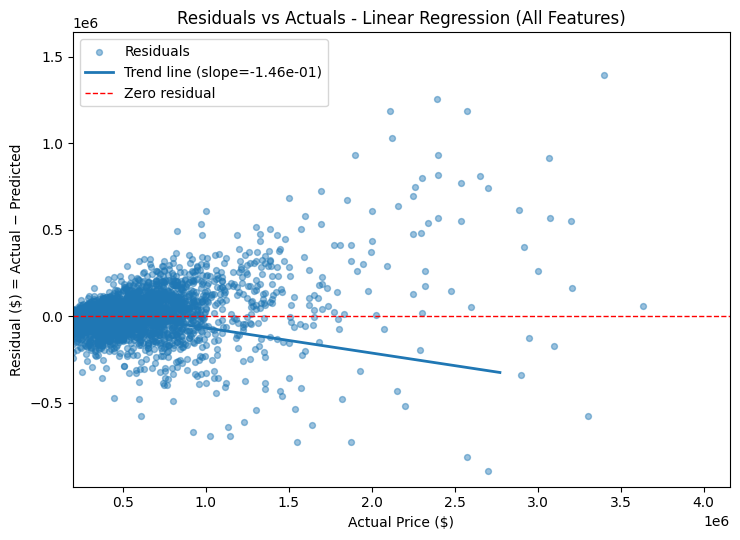

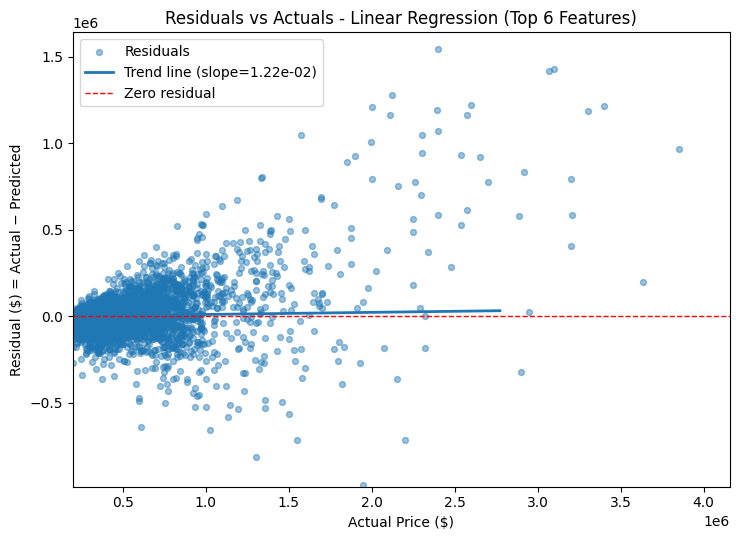

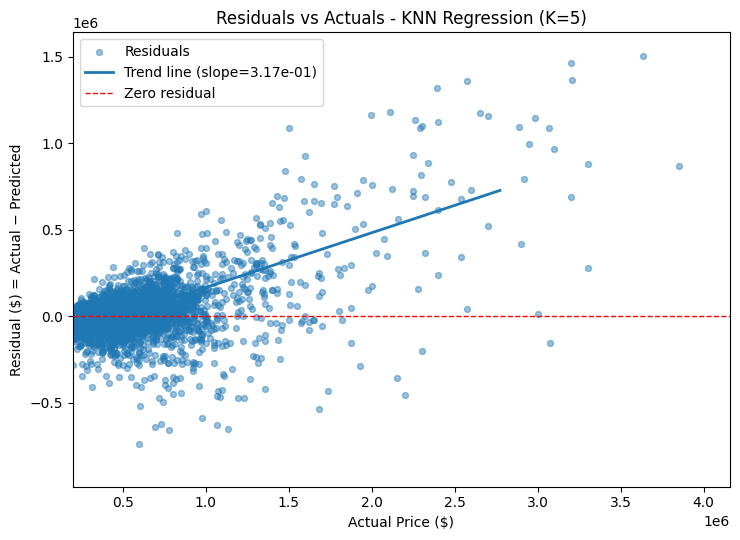

In [78]:

import numpy as np
import matplotlib.pyplot as plt

y_true = np.expm1(y_test_log)  #dollars

#Predictions in dollars for each model
y_pred_lr_all  = np.expm1(pipe.predict(X_test))
y_pred_lr_top6 = np.expm1(pipe_top6.predict(X_test[top6_features]))
y_pred_knn_reg = y_pred_knn_dollar

#residuals (Actual − Predicted)
res_lr_all  = y_true - y_pred_lr_all
res_top6    = y_true - y_pred_lr_top6
res_knn     = y_true - y_pred_knn_reg

#axis limits
x_min = np.percentile(y_true, 0.5)
x_max = np.percentile(y_true, 99.5)
all_res = np.concatenate([res_lr_all, res_top6, res_knn])
y_min = np.percentile(all_res, 0.5)
y_max = np.percentile(all_res, 99.5)

def plot_res(y_true_, resid_, title):
    plt.figure(figsize=(7.5, 5.5))
    plt.scatter(y_true_, resid_, alpha=0.45, s=18, label="Residuals")
    m, b = np.polyfit(y_true_, resid_, 1)
    x_line = np.linspace(x_min, x_max, 200)
    plt.plot(x_line, m*x_line + b, linewidth=2, label=f"Trend line (slope={m:.2e})")
    plt.axhline(0, linestyle="--", linewidth=1, color="red", label="Zero residual")
    plt.xlim(x_min*1.5, x_max*1.5)
    plt.ylim(y_min*2, y_max*2)
    plt.title(title)
    plt.xlabel("Actual Price ($)")
    plt.ylabel("Residual ($) = Actual − Predicted")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_res(y_true, res_lr_all,  "Residuals vs Actuals - Linear Regression (All Features)")
plot_res(y_true, res_top6,    "Residuals vs Actuals - Linear Regression (Top 6 Features)")
plot_res(y_true, res_knn,     f"Residuals vs Actuals - KNN Regression (K={best_k_reg})")


### Linear Regression (All Features) : The residuals show a noticeable funnel shape widening as actual price increases, meaning the model’s prediction error grows for higher-priced homes. This pattern indicates non-constant variance of error terms (heteroscedasticity) - the model fits well for mid-range homes but struggles at the high end. The downward-sloping trend line suggests a mild systematic underestimation for expensive properties. Several high-leverage outliers amplify this effect, likely pulling the regression line down.

### Linear Regression (Top 6 Features) : This model exhibits a slightly tighter and more uniform residual spread, though the funnel shape still persists to a smaller extent. Errors remain relatively balanced around zero for most observations, showing less bias than the full-feature model. However, the slight increase in variance among higher-priced homes indicates that while feature reduction simplified the model and reduced overfitting, it hasn’t fully eliminated heteroscedasticity or the influence of price outliers.

### KNN Regression (K=5) : The KNN regression plot shows an upward-sloping trend line, meaning the model tends to underpredict high-value homes and overpredict lower-value ones - a classic case of local averaging behavior in KNN. The residuals are more randomly dispersed at lower prices but flare out substantially at higher prices, again signaling non-constant error variance. The upper tail reveals a few extreme points acting as outliers or high-leverage samples where neighborhood density is sparse, reducing local accuracy.

# Using XGBoost Regressor as an extra algortithm

In [79]:
try:
    from xgboost import XGBRegressor
except ImportError as e:
    raise SystemExit(
        "xgboost is not installed in this environment.\n"
        "Install it and re-run:\n"
        "  pip install xgboost\n"
    ) from e

#using the same pipeline for preprocessing
pipe_xgb = Pipeline([
    ("pre", preprocessor),
    ("model", XGBRegressor(
        objective="reg:squarederror",
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        tree_method="hist",
        n_jobs=-1,
        random_state=1
    ))
])

#fit on log-price
pipe_xgb.fit(X_train, y_train_log)

#Predict
y_pred_xgb_log    = pipe_xgb.predict(X_test)
y_pred_xgb_dollar = np.expm1(y_pred_xgb_log)

#Metrics in dollar scale
y_true_dollar = np.expm1(y_test_log)
rmse_xgb = np.sqrt(mean_squared_error(y_true_dollar, y_pred_xgb_dollar))
mae_xgb  = mean_absolute_error(y_true_dollar, y_pred_xgb_dollar)
r2_xgb   = r2_score(y_true_dollar, y_pred_xgb_dollar)

#appending to comparison table
summary = pd.concat([
    summary,
    pd.DataFrame([{
        "Model": "XGBoost Regression",
        "Metric Type": "Continuous (R-sqr., RMSE, MAE)",
        "R-sqr.": f"{r2_xgb:.4f}",
        "RMSE": f"${rmse_xgb:,.0f}",
        "MAE": f"${mae_xgb:,.0f}",
    }])
], ignore_index=True)

print("\nUpdated Model Performance Comparison (with XGBoost)")
print(tabulate(summary, headers="keys", tablefmt="github", showindex=False))




Updated Model Performance Comparison (with XGBoost)
| Model                     | Metric Type                    |   R-sqr. | RMSE     | MAE     |
|---------------------------|--------------------------------|----------|----------|---------|
| Linear Regression (Top-6) | Continuous (R-sqr., RMSE, MAE) |   0.6408 | $248,980 | $90,485 |
| KNN Regression (K=5)      | Continuous (R-sqr., RMSE, MAE) |   0.7653 | $201,266 | $88,467 |
| XGBoost Regression        | Continuous (R-sqr., RMSE, MAE) |   0.8674 | $151,278 | $65,343 |


### XGBoost (R-sqr. = 0.8674) clearly outperforms both KNN and linear regression with the lowest RMSE (151 K) and MAE (65 K), confirming its ability to model complex nonlinear interactions and variable importance using gradient-boosted trees. Unlike KNN’s memory-based local predictions or linear regression’s fixed global coefficients, XGBoost builds an ensemble of weak learners that systematically reduce bias and variance making it the most robust and accurate model among the three.

# Residual plot for XGBoost

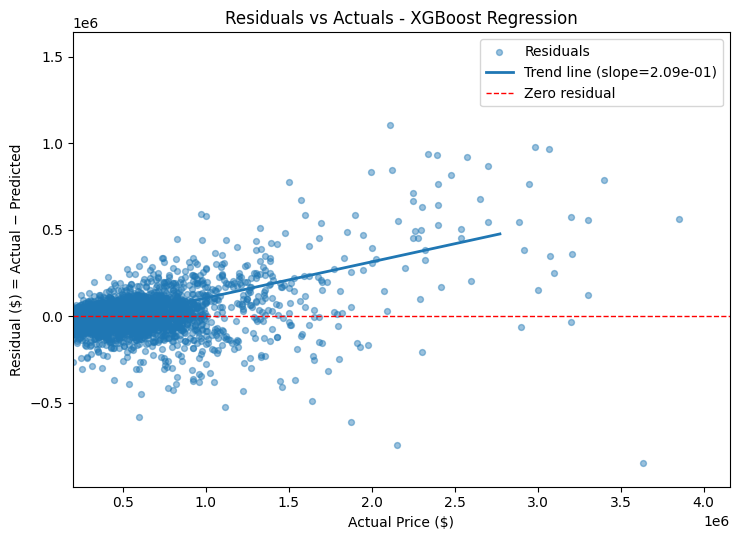

In [80]:
#reusing existing x and y variables and the same plot_res()
y_true = np.expm1(y_test_log)
res_xgb = y_true - y_pred_xgb_dollar

plot_res(y_true, res_xgb, "Residuals vs Actuals - XGBoost Regression")

### The residual plot shows a funnel-shaped spread, where residuals widen as actual prices increase which is a classic sign of heteroscedasticity or non-constant variance of error terms. This means the model’s prediction errors grow for higher-priced houses, suggesting it fits lower and mid-priced homes better than luxury ones. The upward trend in the residuals and a few high-leverage outliers (points far from the main cluster) indicate that while XGBoost captures overall nonlinear patterns well, it still struggles to generalize for extreme property values, possibly due to limited high-end training data or skewed feature distributions.

## Saving model

In [81]:
import joblib, os
os.makedirs("outputs", exist_ok=True)
joblib.dump(pipe_xgb, "../outputs/xgb_price_model.joblib")
print("Saved: outputs/xgb_price_model.joblib")

Saved: outputs/xgb_price_model.joblib
